In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5 # Some random function to understand stuff

In [4]:
f(3.0)

20.0

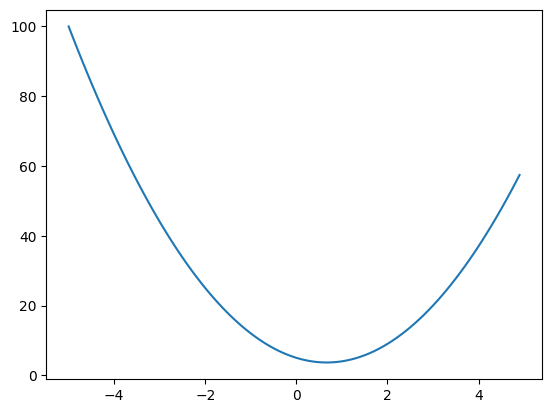

In [5]:
xs = np.arange(-5, 5, 0.1)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
a= 3.0
b = -2.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

a = 3.0
b = -2.0
c = 10.0

d1 = a*b + c
a+=h
d2 = a*b + c

print((d2-d1)/h) # derivative of d wrt a

-2.0000000000042206


In [8]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.grad = 0.0
        self.label = label

    def __repr__(self):
        return f"Value(date={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out 
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __neg__(self):
        return self * -1.0
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + (-other.data), (self, other), '-')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward
        return out
    
    def __rsub__(self, other): # other - self
        return self.__neg__() + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Other must be int, float or Value"
        out = Value(self.data**other, (self,), '**')
        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self, other), '/')
        def _backward():
            self.grad += 1.0 / other.data * out.grad
            other.grad += -self.data / other.data**2 * out.grad
        out._backward = _backward
        return out

    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        def _backward():
            self.grad += math.exp(self.data) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        out = Value(math.tanh(self.data), (self,), 'tanh')
        def _backward():
            self.grad = (1.0 - out.data**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        self.grad = 1.0
        visited = set()
        def _backward(v):
            if v not in visited:
                visited.add(v)
                v._backward()
                for child in v._prev:
                    _backward(child)
        _backward(self) 

In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

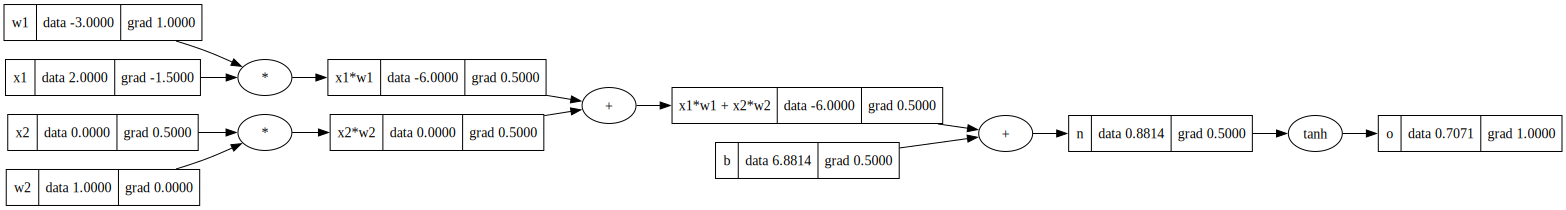

In [11]:
draw_dot(o)

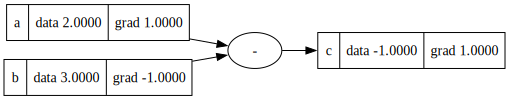

In [12]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')

c = a - b; c.label = 'c'
c.backward()
draw_dot(c)

In [13]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = ((2*n).exp() - 1)/((2*n).exp() + 1); o.label = 'o'

o.backward()

In [14]:
import torch

In [15]:
import random

In [16]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [17]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [18]:
n = MLP(3, [4, 4, 1])

In [61]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    # compute loss
    loss = sum(((yout - ygt)**2) for ygt, yout in zip(ys, ypred))
    # zero gradients
    for p in n.parameters():
        p.grad = 0.0
    # backward pass
    loss.backward()
    # optimisation
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 3.9839871989745394e-05
1 3.983564186224721e-05
2 3.983119153834539e-05
3 3.9826099683750364e-05
4 3.982185648883218e-05
5 3.981740156400156e-05
6 3.981232457159491e-05
7 3.980781165293617e-05
8 3.980357911065651e-05
9 3.979906064970943e-05
10 3.979483410839981e-05
11 3.97897592968523e-05
12 3.9785242393979366e-05
13 3.97810187436513e-05
14 3.977679184776534e-05
15 3.97715134278766e-05
16 3.976673200932907e-05
17 3.976251505973815e-05
18 3.975724068426918e-05
19 3.97522451633554e-05


In [62]:
ypred

[Value(date=0.9979621167351455),
 Value(date=-0.99799448176035),
 Value(date=-0.9958156642660452),
 Value(date=0.9962491990164551)]

In [34]:
n.parameters()

[Value(date=-0.6082309615577818),
 Value(date=-0.6638132112090921),
 Value(date=0.1956629503788343),
 Value(date=-0.6804578697373534),
 Value(date=-0.6205976883826002),
 Value(date=-0.8381108625187949),
 Value(date=-0.2708394591022218),
 Value(date=-0.07478570350726042),
 Value(date=0.7781384865246322),
 Value(date=0.734622091129067),
 Value(date=-0.6323063118753414),
 Value(date=0.9652835363390823),
 Value(date=-0.2439763587499305),
 Value(date=0.4941786136776659),
 Value(date=-0.7879288947584641),
 Value(date=-0.1265867461527383),
 Value(date=0.24885481272213716),
 Value(date=-0.24591461147413823),
 Value(date=-0.33829401176303286),
 Value(date=-1.6690668671723135),
 Value(date=0.5543610202309676),
 Value(date=-0.9232262380231591),
 Value(date=-0.7928909060851816),
 Value(date=0.9912767029453616),
 Value(date=-0.32660865575037096),
 Value(date=-0.41086335374483973),
 Value(date=-0.15884447742050178),
 Value(date=-0.02703091675138678),
 Value(date=-0.36349426665026924),
 Value(date=1.